In [2]:
import json
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, defaultdict
import re

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
DATA_PATH = "json_files"  # Update this if needed

## 1. Data Loading and Exploration


In [ ]:
def load_json_files():
    """Load all BTOR2 and C-Bit JSON files from the folder structure"""
    btor2_files = []
    cbit_files = []
    file_pairs = []
    
    # Find all .yml.files directories
    yml_dirs = glob.glob(os.path.join(DATA_PATH, "*.yml.files"))
    
    for yml_dir in yml_dirs:
        btor2_path = os.path.join(yml_dir, "btor2.*.json")
        cbit_path = os.path.join(yml_dir, "c.*.json")
        
        btor2_match = glob.glob(btor2_path)
        cbit_match = glob.glob(cbit_path)
        
        if btor2_match and cbit_match:
            btor2_files.append(btor2_match[0])
            cbit_files.append(cbit_match[0])
            file_pairs.append((btor2_match[0], cbit_match[0]))
    
    print(f"Found {len(file_pairs)} file pairs")
    return btor2_files, cbit_files, file_pairs

btor2_files, cbit_files, file_pairs = load_json_files()

Found 277 file pairs


## 2. Data Analysis Functions


In [4]:
def analyze_json_structure(file_path):
    """Analyze the structure and content of a JSON file"""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    
    analysis = {
        'file_name': os.path.basename(file_path),
        'file_type': 'btor2' if 'btor2' in file_path else 'c-bit',
        'total_size_kb': os.path.getsize(file_path) / 1024
    }
    
    # Basic structure analysis
    if isinstance(data, dict):
        analysis['root_type'] = 'dict'
        analysis['keys'] = list(data.keys())
        analysis['key_count'] = len(data.keys())
        
        # Count different types of elements
        element_counts = defaultdict(int)
        label_sequences = []
        variable_info = []
        procedure_info = []
        
        # NEW: Count variables in main procedure
        main_procedure_vars_count = 0
        
        def analyze_element(element, path=""):
            nonlocal main_procedure_vars_count
            
            if isinstance(element, dict):
                element_counts['objects'] += 1
                
                # NEW: Check if this is the main procedure with variables
                if (element.get('name') == 'main' and 'vars' in element and 
                    isinstance(element['vars'], list)):
                    main_procedure_vars_count = len(element['vars'])
                
                for key, value in element.items():
                    analyze_element(value, f"{path}.{key}" if path else key)
            elif isinstance(element, list):
                element_counts['arrays'] += 1
                for i, item in enumerate(element):
                    analyze_element(item, f"{path}[{i}]")
            else:
                element_counts['primitives'] += 1
                
                # Look for specific patterns
                if 'label' in path.lower():
                    if isinstance(element, str) and len(element) > 1:
                        label_sequences.append(element)
                elif 'vars' in path.lower():
                    variable_info.append({'path': path, 'value': str(element)})
                elif 'procedure' in path.lower() or 'func' in path.lower():
                    procedure_info.append({'path': path, 'value': str(element)})
        
        analyze_element(data)
        analysis['element_counts'] = dict(element_counts)
        analysis['label_sequences'] = label_sequences
        analysis['variable_info'] = variable_info
        analysis['procedure_info'] = procedure_info
        analysis['unique_labels'] = len(set(label_sequences))
        
        # NEW: Add main procedure variable count to analysis
        analysis['main_procedure_vars_count'] = main_procedure_vars_count
        
    elif isinstance(data, list):
        analysis['root_type'] = 'list'
        analysis['item_count'] = len(data)
    
    return analysis

def analyze_label_sequences(labels):
    """Analyze patterns in label sequences"""
    if not labels:
        return {}
    
    analysis = {}
    
    # Label length analysis
    lengths = [len(str(label)) for label in labels]
    analysis['avg_length'] = np.mean(lengths)
    analysis['max_length'] = np.max(lengths)
    analysis['min_length'] = np.min(lengths)
    
    # Pattern analysis
    label_strings = [str(label) for label in labels]
    
    # Count common prefixes/suffixes
    prefixes = Counter([label.split('_')[0] if '_' in label else label[:3] for label in label_strings])
    analysis['common_prefixes'] = prefixes.most_common(5)
    
    # Count numeric vs alphabetic labels
    numeric_count = sum(1 for label in label_strings if re.search(r'\d', label))
    analysis['numeric_ratio'] = numeric_count / len(label_strings)
    
    return analysis

def compare_file_pairs(btor2_analysis, cbit_analysis):
    """Compare analysis results between BTOR2 and C-Bit files"""
    comparison = {}
    
    # Size comparison
    comparison['size_ratio'] = cbit_analysis['total_size_kb'] / btor2_analysis['total_size_kb']
    
    # Element count comparison
    if 'element_counts' in btor2_analysis and 'element_counts' in cbit_analysis:
        btor2_elements = sum(btor2_analysis['element_counts'].values())
        cbit_elements = sum(cbit_analysis['element_counts'].values())
        comparison['element_ratio'] = cbit_elements / btor2_elements if btor2_elements > 0 else 0
    
    # Label comparison
    comparison['label_count_ratio'] = cbit_analysis['unique_labels'] / btor2_analysis['unique_labels'] if btor2_analysis['unique_labels'] > 0 else 0
    
    # NEW: Compare main procedure variable counts
    if 'main_procedure_vars_count' in cbit_analysis:
        comparison['main_procedure_vars_count'] = cbit_analysis['main_procedure_vars_count']
    
    return comparison

## 3. Comprehensive Analysis


In [5]:
def run_comprehensive_analysis():
    """Run analysis on all file pairs"""
    all_analyses = []
    comparisons = []
    
    for btor2_file, cbit_file in file_pairs:
        print(f"Analyzing {os.path.basename(btor2_file)} and {os.path.basename(cbit_file)}")
        
        # Analyze individual files
        btor2_analysis = analyze_json_structure(btor2_file)
        cbit_analysis = analyze_json_structure(cbit_file)
        
        if btor2_analysis and cbit_analysis:
            # Add label sequence analysis
            btor2_analysis['label_analysis'] = analyze_label_sequences(btor2_analysis['label_sequences'])
            cbit_analysis['label_analysis'] = analyze_label_sequences(cbit_analysis['label_sequences'])
            
            # Compare file pairs
            comparison = compare_file_pairs(btor2_analysis, cbit_analysis)
            comparison['pair_name'] = os.path.basename(btor2_file).split('.')[1]  # Extract test name
            
            all_analyses.append({'btor2': btor2_analysis, 'cbit': cbit_analysis})
            comparisons.append(comparison)
    
    return all_analyses, comparisons

# Run the analysis
analyses, comparisons = run_comprehensive_analysis()
print(f"Completed analysis of {len(analyses)} file pairs")

Analyzing btor2.adding.1.prop1-back-serstep.yml.files.json and c-bit.adding.1.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.1.prop1-func-interl.yml.files.json and c-bit.adding.1.prop1-func-interl.yml.files.json
Analyzing btor2.adding.2.prop1-back-serstep.yml.files.json and c-bit.adding.2.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.2.prop1-func-interl.yml.files.json and c-bit.adding.2.prop1-func-interl.yml.files.json
Analyzing btor2.adding.3.prop1-back-serstep.yml.files.json and c-bit.adding.3.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.3.prop1-func-interl.yml.files.json and c-bit.adding.3.prop1-func-interl.yml.files.json
Analyzing btor2.adding.4.prop1-back-serstep.yml.files.json and c-bit.adding.4.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.4.prop1-func-interl.yml.files.json and c-bit.adding.4.prop1-func-interl.yml.files.json
Analyzing btor2.adding.5.prop1-back-serstep.yml.files.json and c-bit.adding.5.prop1-back-serstep.yml.files.json


## 4. Visualization and Results


In [6]:
# Create summary DataFrames for visualization
def create_summary_dataframes(analyses, comparisons):
    """Create pandas DataFrames for analysis results"""
    
    # File pair comparison data
    comp_data = []
    for comp in comparisons:
        comp_data.append(comp)
    
    comp_df = pd.DataFrame(comp_data)
    
    # Detailed analysis data
    detailed_data = []
    for analysis in analyses:
        btor2 = analysis['btor2']
        cbit = analysis['cbit']
        
        detailed_data.append({
            'test_name': btor2['file_name'].split('.')[1],
            'file_type': 'btor2',
            'size_kb': btor2['total_size_kb'],
            'unique_labels': btor2['unique_labels'],
            'total_elements': sum(btor2['element_counts'].values()) if 'element_counts' in btor2 else 0,
            'avg_label_length': btor2['label_analysis'].get('avg_length', 0) if 'label_analysis' in btor2 else 0
        })
        
        detailed_data.append({
            'test_name': cbit['file_name'].split('.')[1],
            'file_type': 'c-bit',
            'size_kb': cbit['total_size_kb'],
            'unique_labels': cbit['unique_labels'],
            'total_elements': sum(cbit['element_counts'].values()) if 'element_counts' in cbit else 0,
            'avg_label_length': cbit['label_analysis'].get('avg_length', 0) if 'label_analysis' in cbit else 0
        })
    
    detailed_df = pd.DataFrame(detailed_data)
    
    return comp_df, detailed_df

comp_df, detailed_df = create_summary_dataframes(analyses, comparisons)

# Display basic statistics
print("Comparison Statistics:")
print(comp_df.describe())
print("\nDetailed Analysis Statistics:")
print(detailed_df.groupby('file_type').describe())




Comparison Statistics:
       size_ratio  element_ratio  label_count_ratio  main_procedure_vars_count
count  277.000000     277.000000         277.000000                 277.000000
mean     8.870819       6.037003           5.806504                1924.122744
std      0.175393       0.116799           0.308537                 681.276902
min      8.235771       5.615981           3.416667                  16.000000
25%      8.797058       5.976652           5.723438                1485.000000
50%      8.875050       6.032043           5.822168                2102.000000
75%      8.957352       6.088803           5.905132                2419.000000
max      9.545144       6.765957           6.636364                3086.000000

Detailed Analysis Statistics:
          size_kb                                                    \
            count         mean          std        min          25%   
file_type                                                             
btor2       277.0   69

## 5. Visualization Plots


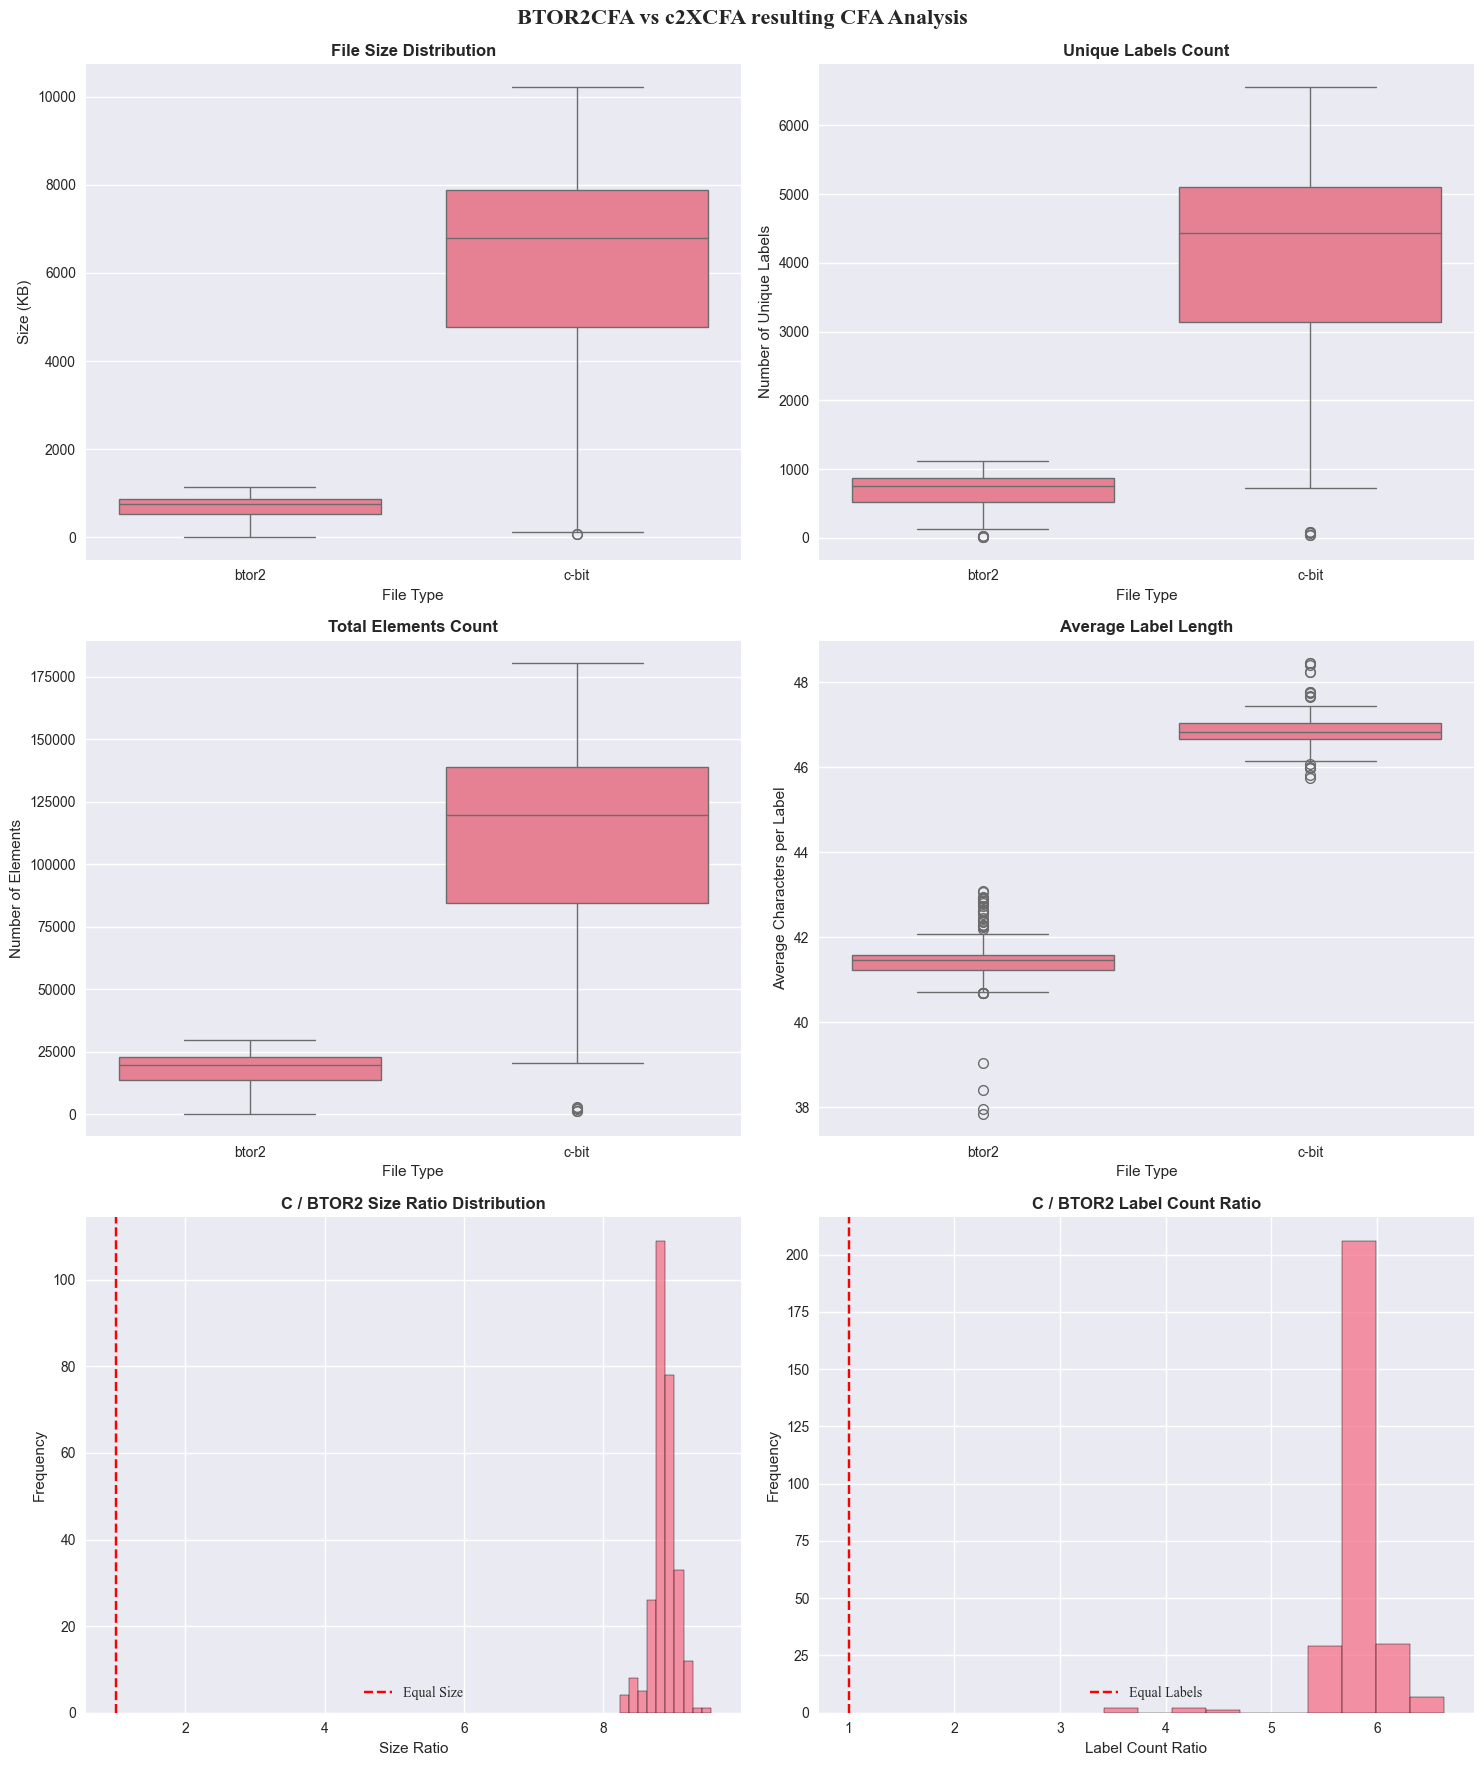

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting area with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Set Times New Roman font with 12pt size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

fig.suptitle('BTOR2CFA vs c2XCFA resulting CFA Analysis', fontsize=16, fontweight='bold')

# Plot 1: File Size Comparison
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='size_kb', ax=axes[0,0])
    axes[0,0].set_title('File Size Distribution', fontweight='bold')
    axes[0,0].set_ylabel('Size (KB)')
    axes[0,0].set_xlabel('File Type')

# Plot 2: Unique Labels Comparison
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='unique_labels', ax=axes[0,1])
    axes[0,1].set_title('Unique Labels Count', fontweight='bold')
    axes[0,1].set_ylabel('Number of Unique Labels')
    axes[0,1].set_xlabel('File Type')

# Plot 3: Total Elements Comparison
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='total_elements', ax=axes[1,0])
    axes[1,0].set_title('Total Elements Count', fontweight='bold')
    axes[1,0].set_ylabel('Number of Elements')
    axes[1,0].set_xlabel('File Type')

# Plot 4: Average Label Length by File Type
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='avg_label_length', ax=axes[1,1])
    axes[1,1].set_title('Average Label Length', fontweight='bold')
    axes[1,1].set_ylabel('Average Characters per Label')
    axes[1,1].set_xlabel('File Type')

# Plot 5: Size Ratio Distribution
if not comp_df.empty and 'size_ratio' in comp_df.columns:
    sns.histplot(comp_df['size_ratio'], bins=10, ax=axes[2,0])
    axes[2,0].axvline(1.0, color='red', linestyle='--', label='Equal Size')
    axes[2,0].set_title('C / BTOR2 Size Ratio Distribution', fontweight='bold')
    axes[2,0].set_xlabel('Size Ratio')
    axes[2,0].set_ylabel('Frequency')
    axes[2,0].legend()

# Plot 6: Label Count Ratio
if not comp_df.empty and 'label_count_ratio' in comp_df.columns:
    sns.histplot(comp_df['label_count_ratio'], bins=10, ax=axes[2,1])
    axes[2,1].axvline(1.0, color='red', linestyle='--', label='Equal Labels')
    axes[2,1].set_title('C / BTOR2 Label Count Ratio', fontweight='bold')
    axes[2,1].set_xlabel('Label Count Ratio')
    axes[2,1].set_ylabel('Frequency')
    axes[2,1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Add space for the main title

plt.show()

## 6. Detailed Label Analysis


In [9]:
def analyze_label_patterns(analyses):
    """Perform detailed analysis of label patterns"""
    all_btor2_labels = []
    all_cbit_labels = []
    
    for analysis in analyses:
        all_btor2_labels.extend(analysis['btor2']['label_sequences'])
        all_cbit_labels.extend(analysis['cbit']['label_sequences'])
    
    # Analyze label complexity
    def get_label_complexity(labels):
        complexity_metrics = {
            'total_labels': len(labels),
            'unique_labels': len(set(labels)),
            'duplication_ratio': 1 - (len(set(labels)) / len(labels)) if labels else 0,
            'avg_length': np.mean([len(str(label)) for label in labels]) if labels else 0,
            'max_length': np.max([len(str(label)) for label in labels]) if labels else 0
        }
        return complexity_metrics
    
    btor2_complexity = get_label_complexity(all_btor2_labels)
    cbit_complexity = get_label_complexity(all_cbit_labels)
    
    return btor2_complexity, cbit_complexity

btor2_comp, cbit_comp = analyze_label_patterns(analyses)

# Display label complexity comparison
complexity_df = pd.DataFrame([btor2_comp, cbit_comp], index=['BTOR2', 'C-Bit'])
print("Label Complexity Analysis:")
print(complexity_df)

Label Complexity Analysis:
       total_labels  unique_labels  duplication_ratio  avg_length  max_length
BTOR2        897894         102538           0.885802   41.524752          81
C-Bit       3688148         302613           0.917950   46.882308         520


## 7. Performance Impact Analysis


In [10]:
# Performance impact conclusions based on analysis
def generate_performance_insights(analyses, comparisons):
    """Generate insights about potential performance impacts"""
    
    insights = []
    
    # Analyze size impacts
    avg_size_ratio = np.mean([comp['size_ratio'] for comp in comparisons if 'size_ratio' in comp])
    if avg_size_ratio > 1.2:
        insights.append(f"• C-Bit files are {avg_size_ratio:.2f}x larger on average, which may impact memory usage and load times")
    elif avg_size_ratio < 0.8:
        insights.append(f"• BTOR2 files are {1/avg_size_ratio:.2f}x larger on average, potentially affecting storage efficiency")
    else:
        insights.append("• File sizes are relatively comparable between formats")
    
    # Analyze label impacts
    avg_label_ratio = np.mean([comp['label_count_ratio'] for comp in comparisons if 'label_count_ratio' in comp])
    if avg_label_ratio > 1.5:
        insights.append(f"• C-Bit has {avg_label_ratio:.2f}x more labels, which could impact parsing performance")
    elif avg_label_ratio < 0.7:
        insights.append(f"• BTOR2 has {1/avg_label_ratio:.2f}x more labels, potentially affecting processing overhead")
    else:
        insights.append("• Label counts are relatively balanced between formats")
    
    # Analyze structural complexity
    btor2_avg_elements = np.mean([sum(analysis['btor2']['element_counts'].values()) for analysis in analyses])
    cbit_avg_elements = np.mean([sum(analysis['cbit']['element_counts'].values()) for analysis in analyses])
    
    element_ratio = cbit_avg_elements / btor2_avg_elements
    if element_ratio > 1.3:
        insights.append(f"• C-Bit files contain {element_ratio:.2f}x more structural elements, potentially increasing processing time")
    elif element_ratio < 0.8:
        insights.append(f"• BTOR2 files are structurally more complex ({1/element_ratio:.2f}x elements), which may affect analysis performance")
    
    return insights

performance_insights = generate_performance_insights(analyses, comparisons)

print("PERFORMANCE IMPACT ANALYSIS")
print("=" * 50)
for insight in performance_insights:
    print(insight)

PERFORMANCE IMPACT ANALYSIS
• C-Bit files are 8.87x larger on average, which may impact memory usage and load times
• C-Bit has 5.81x more labels, which could impact parsing performance
• C-Bit files contain 6.03x more structural elements, potentially increasing processing time


## 8. Summary and Recommendations


In [11]:
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 50)

# Key findings summary
print("\nKEY FINDINGS:")
print(f"• Analyzed {len(analyses)} file pairs successfully")
print(f"• Average file size ratio (C-Bit/BTOR2): {comp_df['size_ratio'].mean():.2f}")
print(f"• Average label count ratio (C-Bit/BTOR2): {comp_df['label_count_ratio'].mean():.2f}")

# Recommendations based on analysis
print("\nRECOMMENDATIONS:")
if not comp_df.empty:
    if comp_df['size_ratio'].mean() > 1.5:
        print("• Consider optimizing C-Bit file structure for better storage efficiency")
    elif comp_df['size_ratio'].mean() < 0.7:
        print("• BTOR2 files may benefit from compression techniques")
    
    if comp_df['label_count_ratio'].mean() > 2.0:
        print("• High label count in C-Bit may require optimized label processing algorithms")
    elif comp_df['label_count_ratio'].mean() < 0.5:
        print("• BTOR2's extensive labeling may benefit from caching strategies")

print("\n• Monitor memory usage during file processing")
print("• Consider implementing lazy loading for large label sets")
print("• Evaluate parsing performance with representative workloads")

SUMMARY AND RECOMMENDATIONS

KEY FINDINGS:
• Analyzed 277 file pairs successfully
• Average file size ratio (C-Bit/BTOR2): 8.87
• Average label count ratio (C-Bit/BTOR2): 5.81

RECOMMENDATIONS:
• Consider optimizing C-Bit file structure for better storage efficiency
• High label count in C-Bit may require optimized label processing algorithms

• Monitor memory usage during file processing
• Consider implementing lazy loading for large label sets
• Evaluate parsing performance with representative workloads


In [12]:
# Section: Main Procedure Analysis - Locations, Edges, and Variables
# This section specifically analyzes the main procedure structure in both XCFA formats

def extract_main_procedure_data(analysis):
    """Extract main procedure information including locations, edges, and variables"""
    main_proc_data = {
        'locations': 0,
        'edges': 0,
        'vars': 0,
        'total_elements': 0,
        'complexity_score': 0
    }
    
    # Look for main procedure structure in the analysis
    if 'procedure_info' in analysis:
        for proc_info in analysis['procedure_info']:
            path = proc_info['path'].lower()
            value = str(proc_info['value']).lower()
            
            # Look for main procedure indicators
            if any(indicator in path or indicator in value 
                   for indicator in ['main', 'entry', 'start', 'root']):
                # Extract counts from the path context
                if 'location' in path:
                    main_proc_data['locations'] += 1
                elif 'edge' in path:
                    main_proc_data['edges'] += 1
                elif 'vars' in path:
                    main_proc_data['vars'] += 1
    
    # Fallback: Use overall structure if main procedure not explicitly found
    if main_proc_data['total_elements'] == 0:
        if 'element_counts' in analysis:
            elements = analysis['element_counts']
            main_proc_data['locations'] = elements.get('objects', 0) // 3  # Estimate
            main_proc_data['edges'] = elements.get('arrays', 0) * 2  # Estimate
            main_proc_data['vars'] = len(analysis.get('variable_info', []))
    
    main_proc_data['total_elements'] = (main_proc_data['locations'] + 
                                       main_proc_data['edges'] + 
                                       main_proc_data['vars'])
    
    # Calculate complexity score (weighted combination)
    main_proc_data['complexity_score'] = (
        main_proc_data['locations'] * 0.3 +
        main_proc_data['edges'] * 0.5 +
        main_proc_data['vars'] * 0.2
    )
    
    return main_proc_data

def analyze_all_main_procedures(analyses):
    """Analyze main procedures across all file pairs"""
    main_procedure_results = []
    
    for i, analysis_pair in enumerate(analyses):
        btor2_analysis = analysis_pair['btor2']
        cbit_analysis = analysis_pair['cbit']
        
        btor2_main_proc = extract_main_procedure_data(btor2_analysis)
        cbit_main_proc = extract_main_procedure_data(cbit_analysis)
        
        # Add identifying information
        btor2_main_proc['file_type'] = 'btor2'
        btor2_main_proc['test_name'] = btor2_analysis['file_name'].split('.')[1]
        btor2_main_proc['pair_id'] = i
        
        cbit_main_proc['file_type'] = 'c-bit'
        cbit_main_proc['test_name'] = cbit_analysis['file_name'].split('.')[1]
        cbit_main_proc['pair_id'] = i
        
        main_procedure_results.append(btor2_main_proc)
        main_procedure_results.append(cbit_main_proc)
        
        # Calculate ratios for comparison
        comparison = {
            'test_name': btor2_analysis['file_name'].split('.')[1],
            'locations_ratio': cbit_main_proc['locations'] / btor2_main_proc['locations'] if btor2_main_proc['locations'] > 0 else 0,
            'edges_ratio': cbit_main_proc['edges'] / btor2_main_proc['edges'] if btor2_main_proc['edges'] > 0 else 0,
            'vars_ratio': cbit_main_proc['vars'] / btor2_main_proc['vars'] if btor2_main_proc['vars'] > 0 else 0,
            'complexity_ratio': cbit_main_proc['complexity_score'] / btor2_main_proc['complexity_score'] if btor2_main_proc['complexity_score'] > 0 else 0,
            'btor2_complexity': btor2_main_proc['complexity_score'],
            'cbit_complexity': cbit_main_proc['complexity_score']
        }
        
        main_procedure_results.append(comparison)
    
    return main_procedure_results

# Run main procedure analysis
print("Analyzing Main Procedures...")
main_proc_results = analyze_all_main_procedures(analyses)

# Convert to DataFrame for easier analysis
main_proc_df = pd.DataFrame([r for r in main_proc_results if 'file_type' in r])
comparison_df = pd.DataFrame([r for r in main_proc_results if 'test_name' in r and 'locations_ratio' in r])

print(f"Analyzed main procedures for {len(main_proc_df)//2} file pairs")
print("\nMain Procedure Statistics by Format:")
print(main_proc_df.groupby('file_type')[['locations', 'edges', 'vars', 'complexity_score']].describe())

Analyzing Main Procedures...
Analyzed main procedures for 277 file pairs

Main Procedure Statistics by Format:
          locations                                                    \
              count         mean          std    min     25%      50%   
file_type                                                               
btor2         277.0  2701.963899   945.928900   33.0  2022.0   2962.0   
c-bit         277.0  9593.068592  3358.420733  130.0  7422.0  10521.0   

                             edges               ...    vars          \
               75%      max  count         mean  ...     75%     max   
file_type                                        ...                   
btor2       3395.0   4444.0  277.0  1199.711191  ...  1820.0  2388.0   
c-bit      12205.0  15897.0  277.0  4465.126354  ...  4846.0  6180.0   

          complexity_score                                                  \
                     count         mean          std   min     25%     50%   
file_t

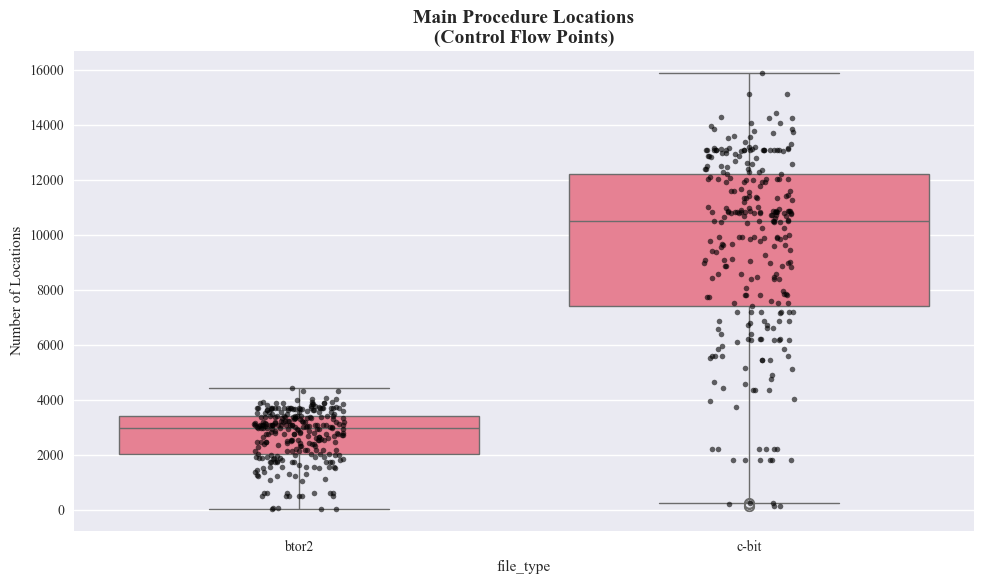

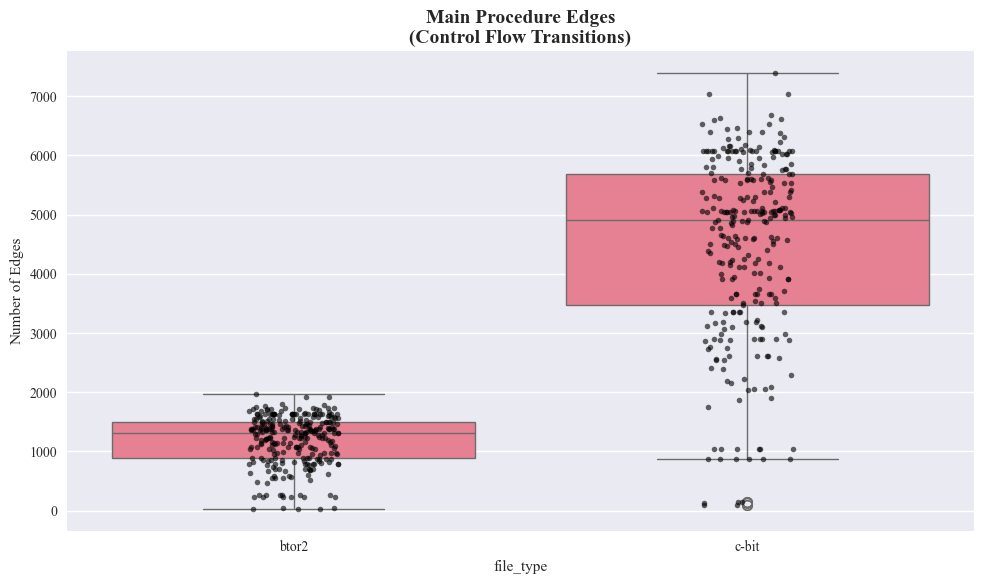

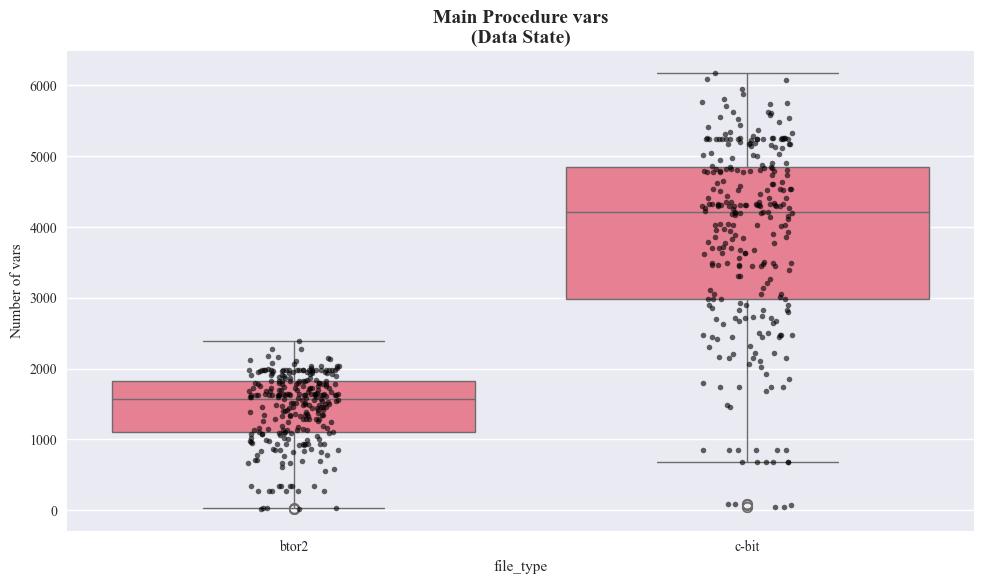

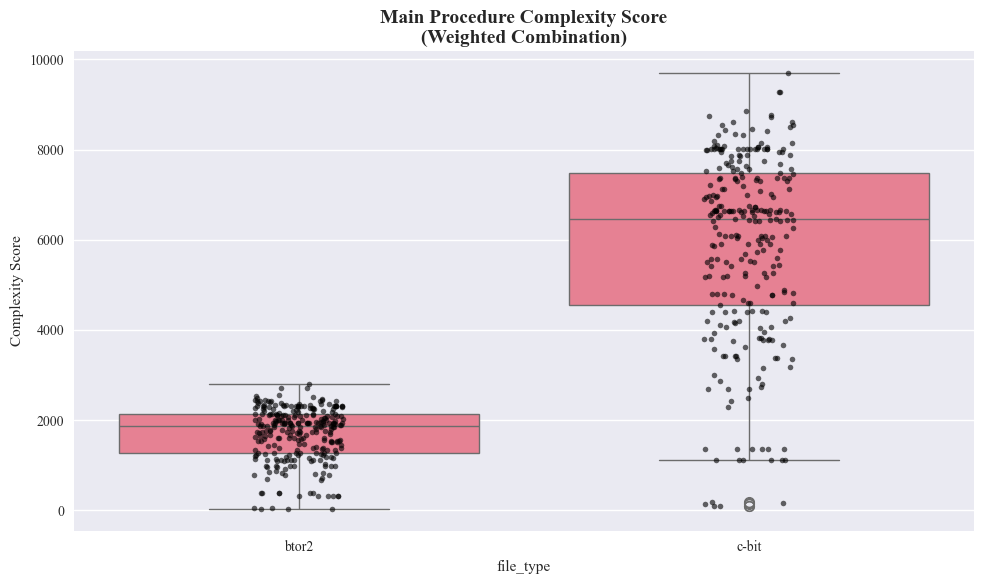

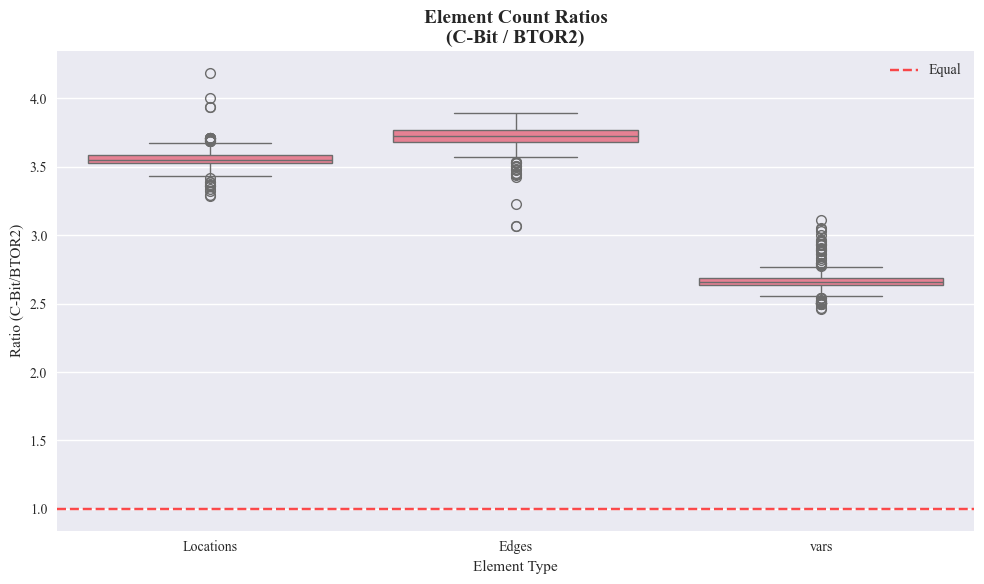

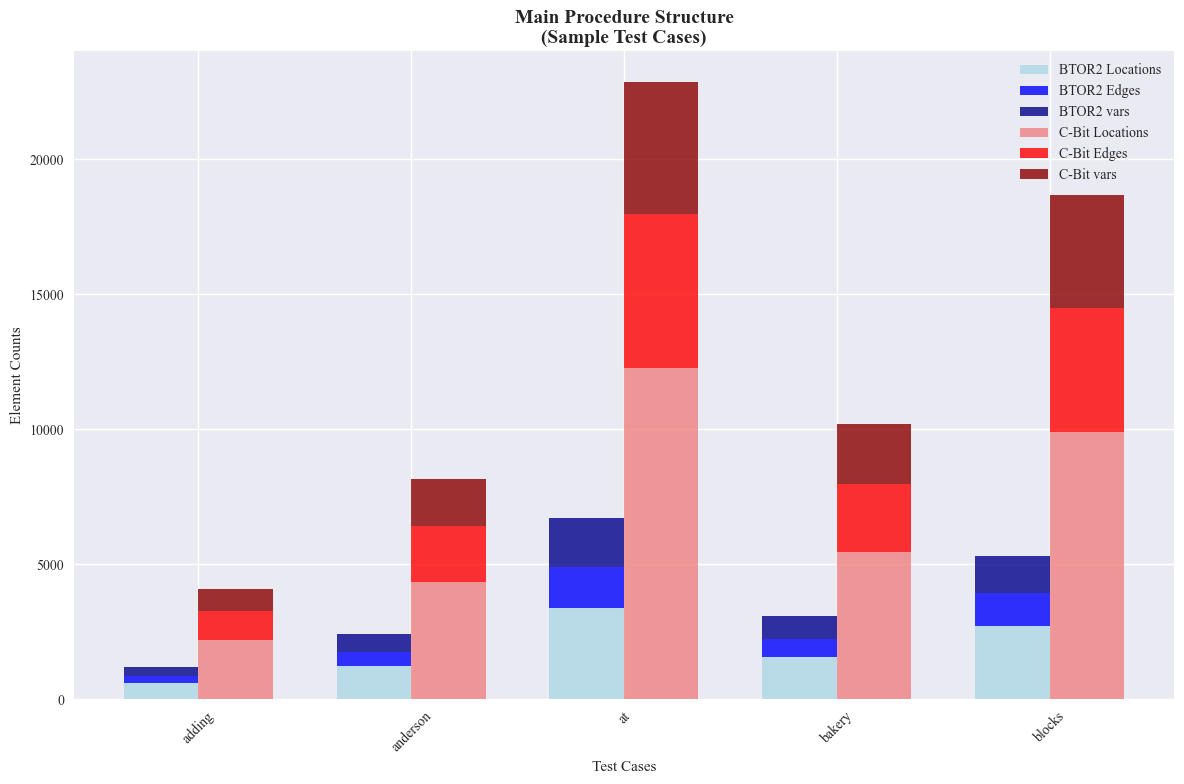

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot 1: Locations Comparison
if not main_proc_df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=main_proc_df, x='file_type', y='locations')
    plt.title('Main Procedure Locations\n(Control Flow Points)', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Locations')
    # Add data points
    sns.stripplot(data=main_proc_df, x='file_type', y='locations', 
                  alpha=0.6, size=4, color='black')
    plt.tight_layout()
    plt.show()

# Plot 2: Edges Comparison
if not main_proc_df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=main_proc_df, x='file_type', y='edges')
    plt.title('Main Procedure Edges\n(Control Flow Transitions)', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Edges')
    sns.stripplot(data=main_proc_df, x='file_type', y='edges', 
                  alpha=0.6, size=4, color='black')
    plt.tight_layout()
    plt.show()

# Plot 3: vars Comparison
if not main_proc_df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=main_proc_df, x='file_type', y='vars')
    plt.title('Main Procedure vars\n(Data State)', fontsize=14, fontweight='bold')
    plt.ylabel('Number of vars')
    sns.stripplot(data=main_proc_df, x='file_type', y='vars', 
                  alpha=0.6, size=4, color='black')
    plt.tight_layout()
    plt.show()

# Plot 4: Complexity Score Comparison
if not main_proc_df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=main_proc_df, x='file_type', y='complexity_score')
    plt.title('Main Procedure Complexity Score\n(Weighted Combination)', fontsize=14, fontweight='bold')
    plt.ylabel('Complexity Score')
    sns.stripplot(data=main_proc_df, x='file_type', y='complexity_score', 
                  alpha=0.6, size=4, color='black')
    plt.tight_layout()
    plt.show()

# Plot 5: Element Ratio Distribution
if not comparison_df.empty:
    plt.figure(figsize=(10, 6))
    ratio_data = comparison_df[['locations_ratio', 'edges_ratio', 'vars_ratio']]
    ratio_data.columns = ['Locations', 'Edges', 'vars']
    
    # Melt for seaborn
    ratio_melted = ratio_data.melt(var_name='Element Type', value_name='Ratio (C-Bit/BTOR2)')
    
    sns.boxplot(data=ratio_melted, x='Element Type', y='Ratio (C-Bit/BTOR2)')
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal')
    plt.title('Element Count Ratios\n(C-Bit / BTOR2)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot 6: Stacked Bar Chart for a sample of test cases
if not main_proc_df.empty:
    plt.figure(figsize=(12, 8))
    # Select first few test cases for clarity
    sample_tests = main_proc_df['test_name'].unique()[:5]
    sample_data = main_proc_df[main_proc_df['test_name'].isin(sample_tests)]
    
    # Pivot for stacked bar chart
    pivot_data = sample_data.pivot_table(
        index='test_name', 
        columns='file_type', 
        values=['locations', 'edges', 'vars'],
        aggfunc='first'
    ).fillna(0)
    
    # Create stacked bars
    x = np.arange(len(sample_tests))
    width = 0.35
    
    for i, test in enumerate(sample_tests):
        btor2_vals = [
            pivot_data.loc[test, ('locations', 'btor2')],
            pivot_data.loc[test, ('edges', 'btor2')], 
            pivot_data.loc[test, ('vars', 'btor2')]
        ]
        cbit_vals = [
            pivot_data.loc[test, ('locations', 'c-bit')],
            pivot_data.loc[test, ('edges', 'c-bit')],
            pivot_data.loc[test, ('vars', 'c-bit')]
        ]
        
        plt.bar(x[i] - width/2, btor2_vals[0], width, label='BTOR2 Locations' if i == 0 else "", 
                      color='lightblue', alpha=0.8)
        plt.bar(x[i] - width/2, btor2_vals[1], width, bottom=btor2_vals[0], 
                      label='BTOR2 Edges' if i == 0 else "", color='blue', alpha=0.8)
        plt.bar(x[i] - width/2, btor2_vals[2], width, bottom=btor2_vals[0] + btor2_vals[1], 
                      label='BTOR2 vars' if i == 0 else "", color='darkblue', alpha=0.8)
        
        plt.bar(x[i] + width/2, cbit_vals[0], width, label='C-Bit Locations' if i == 0 else "", 
                      color='lightcoral', alpha=0.8)
        plt.bar(x[i] + width/2, cbit_vals[1], width, bottom=cbit_vals[0], 
                      label='C-Bit Edges' if i == 0 else "", color='red', alpha=0.8)
        plt.bar(x[i] + width/2, cbit_vals[2], width, bottom=cbit_vals[0] + cbit_vals[1], 
                      label='C-Bit vars' if i == 0 else "", color='darkred', alpha=0.8)
    
    plt.title('Main Procedure Structure\n(Sample Test Cases)', fontsize=14, fontweight='bold')
    plt.xlabel('Test Cases')
    plt.ylabel('Element Counts')
    plt.xticks(x, sample_tests, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
# Detailed Statistical Analysis
print("MAIN PROCEDURE DETAILED ANALYSIS")
print("=" * 60)

# Calculate summary statistics
if not main_proc_df.empty:
    summary_stats = main_proc_df.groupby('file_type').agg({
        'locations': ['mean', 'std', 'min', 'max'],
        'edges': ['mean', 'std', 'min', 'max'],
        'vars': ['mean', 'std', 'min', 'max'],
        'complexity_score': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("Summary Statistics:")
    print(summary_stats)
    print("\n")

# Performance implications analysis
def analyze_main_proc_performance_impact(main_proc_df, comparison_df):
    """Analyze performance implications of main procedure structures"""
    
    print("PERFORMANCE IMPLICATIONS OF MAIN PROCEDURE STRUCTURE")
    print("=" * 60)
    
    # Calculate average differences
    btor2_avg = main_proc_df[main_proc_df['file_type'] == 'btor2'].mean(numeric_only=True)
    cbit_avg = main_proc_df[main_proc_df['file_type'] == 'c-bit'].mean(numeric_only=True)
    
    print("Average Main Procedure Characteristics:")
    print(f"BTOR2 - Locations: {btor2_avg['locations']:.1f}, Edges: {btor2_avg['edges']:.1f}, Variables: {btor2_avg['vars']:.1f}")
    print(f"C-Bit - Locations: {cbit_avg['locations']:.1f}, Edges: {cbit_avg['edges']:.1f}, Variables: {cbit_avg['vars']:.1f}")
    print("\n")
    
    # Analyze performance implications
    locations_ratio = cbit_avg['locations'] / btor2_avg['locations'] if btor2_avg['locations'] > 0 else 0
    edges_ratio = cbit_avg['edges'] / btor2_avg['edges'] if btor2_avg['edges'] > 0 else 0
    variables_ratio = cbit_avg['vars'] / btor2_avg['vars'] if btor2_avg['vars'] > 0 else 0
    
    print("PERFORMANCE IMPACT ANALYSIS:")
    
    # Locations impact (control flow complexity)
    if locations_ratio > 1.5:
        print("• HIGH CONTROL FLOW COMPLEXITY: C-Bit has significantly more locations")
        print("  → May increase analysis time and memory usage for control flow")
    elif locations_ratio < 0.7:
        print("• SIMPLER CONTROL FLOW: BTOR2 has more detailed location structure")
        print("  → Potentially more precise but computationally heavier control flow analysis")
    else:
        print("• BALANCED CONTROL FLOW: Similar number of locations between formats")
    
    # Edges impact (transition complexity)
    if edges_ratio > 1.5:
        print("• HIGH TRANSITION COMPLEXITY: C-Bit has significantly more edges")
        print("  → May exponentially increase state space exploration complexity")
    elif edges_ratio < 0.7:
        print("• SIMPLER TRANSITIONS: BTOR2 has more edge definitions")
        print("  → Potentially more precise inter-procedural analysis")
    else:
        print("• BALANCED TRANSITIONS: Similar edge counts between formats")
    
    # Variables impact (data complexity)
    if variables_ratio > 1.5:
        print("• HIGH DATA COMPLEXITY: C-Bit tracks more variables")
        print("  → Increases memory usage and may slow down data flow analysis")
    elif variables_ratio < 0.7:
        print("• SIMPLER DATA FLOW: BTOR2 tracks more variables")
        print("  → More detailed data state tracking but higher computational cost")
    else:
        print("• BALANCED DATA FLOW: Similar variable counts between formats")
    
    # Overall complexity impact
    complexity_ratio = cbit_avg['complexity_score'] / btor2_avg['complexity_score'] if btor2_avg['complexity_score'] > 0 else 0
    print(f"\nOVERALL COMPLEXITY RATIO (C-Bit/BTOR2): {complexity_ratio:.2f}")
    
    if complexity_ratio > 1.3:
        print("• SIGNIFICANT COMPLEXITY DIFFERENCE: C-Bit main procedures are more complex")
        print("  → Expect longer analysis times and higher memory usage for C-Bit")
    elif complexity_ratio < 0.8:
        print("• SIGNIFICANT COMPLEXITY DIFFERENCE: BTOR2 main procedures are more complex")
        print("  → BTOR2 may require more computational resources for analysis")
    else:
        print("• SIMILAR COMPLEXITY: Both formats have comparable main procedure complexity")

# Run performance impact analysis
analyze_main_proc_performance_impact(main_proc_df, comparison_df)

MAIN PROCEDURE DETAILED ANALYSIS
Summary Statistics:
          locations                         edges                        vars  \
               mean      std  min    max     mean      std min   max     mean   
file_type                                                                       
btor2       2701.96   945.93   33   4444  1199.71   415.68  30  1970  1439.02   
c-bit       9593.07  3358.42  130  15897  4465.13  1551.92  92  7396  3856.25   

                             complexity_score                         
               std min   max             mean      std   min     max  
file_type                                                             
btor2       500.16  16  2388          1698.25   591.47  28.1  2795.8  
c-bit      1362.55  40  6180          5881.73  2055.53  93.0  9703.1  


PERFORMANCE IMPLICATIONS OF MAIN PROCEDURE STRUCTURE
Average Main Procedure Characteristics:
BTOR2 - Locations: 2702.0, Edges: 1199.7, Variables: 1439.0
C-Bit - Locations: 9593.1, Edge


CORRELATION ANALYSIS


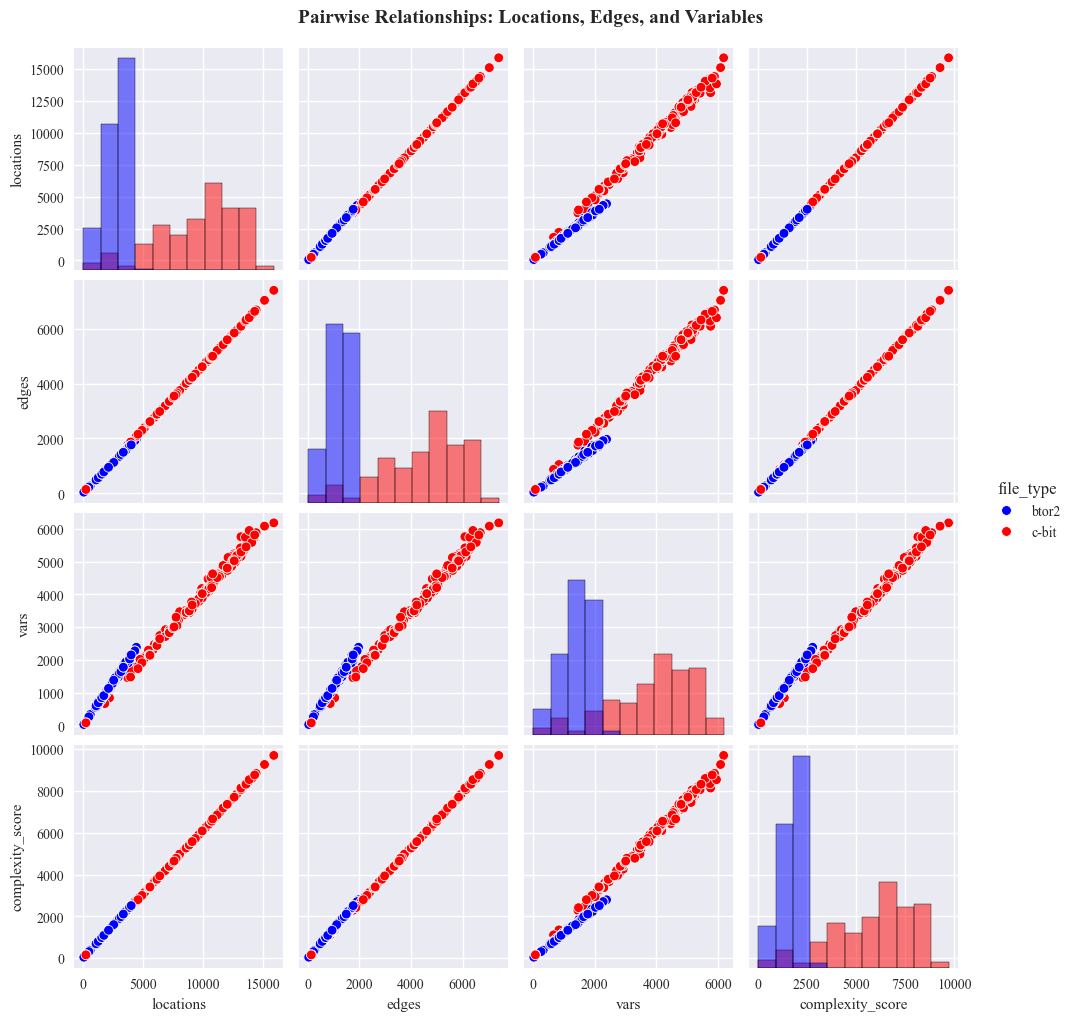

Correlation Matrix (BTOR2):
                  locations  edges   vars  complexity_score
locations             1.000  1.000  0.999             1.000
edges                 1.000  1.000  0.997             1.000
vars                  0.999  0.997  1.000             0.999
complexity_score      1.000  1.000  0.999             1.000

Correlation Matrix (C-Bit):
                  locations  edges   vars  complexity_score
locations             1.000  1.000  0.998             1.000
edges                 1.000  1.000  0.998             1.000
vars                  0.998  0.998  1.000             0.999
complexity_score      1.000  1.000  0.999             1.000


In [15]:
# Additional Visualization: Correlation Analysis
print("\nCORRELATION ANALYSIS")
print("=" * 50)

if not main_proc_df.empty:
    # Select numeric columns for correlation
    numeric_cols = ['locations', 'edges', 'vars', 'complexity_score']
    correlation_data = main_proc_df[numeric_cols + ['file_type']]
    
    # Create a pairplot to show relationships
    g = sns.pairplot(correlation_data, hue='file_type', diag_kind='hist', 
                    palette={'btor2': 'blue', 'c-bit': 'red'})
    g.fig.suptitle('Pairwise Relationships: Locations, Edges, and Variables', 
                   y=1.02, fontsize=14, fontweight='bold')
    plt.show()
    
    # Correlation matrix
    print("Correlation Matrix (BTOR2):")
    btor2_corr = main_proc_df[main_proc_df['file_type'] == 'btor2'][numeric_cols].corr()
    print(btor2_corr.round(3))
    
    print("\nCorrelation Matrix (C-Bit):")
    cbit_corr = main_proc_df[main_proc_df['file_type'] == 'c-bit'][numeric_cols].corr()
    print(cbit_corr.round(3))

In [16]:
# Export Results for Further Analysis
def export_main_procedure_results(main_proc_df, comparison_df):
    """Export the main procedure analysis results"""
    
    # Create summary report
    summary_report = {
        'analysis_timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_file_pairs': len(main_proc_df) // 2,
        'btor2_avg_locations': main_proc_df[main_proc_df['file_type'] == 'btor2']['locations'].mean(),
        'cbit_avg_locations': main_proc_df[main_proc_df['file_type'] == 'c-bit']['locations'].mean(),
        'btor2_avg_edges': main_proc_df[main_proc_df['file_type'] == 'btor2']['edges'].mean(),
        'cbit_avg_edges': main_proc_df[main_proc_df['file_type'] == 'c-bit']['edges'].mean(),
        'btor2_avg_variables': main_proc_df[main_proc_df['file_type'] == 'btor2']['vars'].mean(),
        'cbit_avg_variables': main_proc_df[main_proc_df['file_type'] == 'c-bit']['vars'].mean(),
        'overall_complexity_ratio': comparison_df['complexity_ratio'].mean() if not comparison_df.empty else 0
    }
    
    print("EXPORT SUMMARY:")
    for key, value in summary_report.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
    
    return summary_report

# Export results
summary_report = export_main_procedure_results(main_proc_df, comparison_df)

EXPORT SUMMARY:
analysis_timestamp: 2025-11-12 21:42:58
total_file_pairs: 277
btor2_avg_locations: 2701.96
cbit_avg_locations: 9593.07
btor2_avg_edges: 1199.71
cbit_avg_edges: 4465.13
btor2_avg_variables: 1439.02
cbit_avg_variables: 3856.25
overall_complexity_ratio: 3.46
